In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import os
from tqdm import tqdm

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from preprocessing import load_cleaned_metadata, clean_text_lda, get_clean_write
from data_access import get_txt
from my_lda import MyCorpus
import my_lda

In [2]:
# df = load_cleaned_metadata('data/processed/metadata_clean.csv.gz')
# len(df)

In [3]:
# # 2021 only
# df.date = pd.to_datetime(df.date)
# df = df[df.date.apply(lambda x: x.year == 2021)]
# len(df)

In [4]:
# df.to_csv('results/final_models/metadata_2021.csv.gz', index=False, sep='\t', compression='gzip')

In [2]:
df = pd.read_csv('results/final_models/metadata_2021.csv.gz', sep='\t', compression='gzip')
df.date = pd.to_datetime(df.date)
len(df)

53758

In [7]:
# # 2000 onwards
# df.date = pd.to_datetime(df.date)
# df = df[df.date.apply(lambda x: x.year >= 2000)]
# len(df)

# Create data files of clean data

In [8]:
# # to save time, clean only files for ids that aren't already in the directory

# dest_directory = 'results/final_models/lda_2000plus_corpus_clean/'
# existing_files = os.listdir(dest_directory)
# ids = df.cord_uid.tolist()
# missing_ids = [i for i in ids if f'{i}_clean.txt' not in existing_files]
# print(len(ids))
# print(len(existing_files))
# print(len(missing_ids))

276669
190338
86331


In [9]:
# for uid in tqdm(missing_ids):
#     get_clean_write(uid, dest_directory)

100%|██████████| 86331/86331 [1:30:24<00:00, 15.92it/s]  


In [12]:
# len(os.listdir('results/final_models/lda2000plus_corpus_clean/'))

## Create corpus and dictionary

Required output:
- topic profile of every document
- visualisation of topics

> "[Gensim](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html#corpus-streaming-tutorial) accepts any object that, when iterated over, successively yields documents."

In [3]:
# list of full paths for documents to be accessed
corpus_directory = 'results/final_models/lda_2021_corpus_clean/'
# ids = df.cord_uid.tolist()
doc_path_list = [corpus_directory + file for file in os.listdir(corpus_directory) if file.endswith('.txt')]
# initiate corpus object
save_directory = 'results/final_models/'
dictionary = Dictionary.load(save_directory + 'dictionary.dict')
corpus = MyCorpus(doc_path_list, dictionary=dictionary)

In [5]:
# save_directory = 'results/final_models/'
# corpus.make_dictionary(save_directory, 'dictionary')

In [6]:
# # filter extremes
# corpus.filter_extremes(no_below=5, no_above=0.2)

In [7]:
print(len(corpus))
print(len(corpus.dictionary))

53758
100000


### Train model

In [13]:
num_topics = 100
alpha = 0.01
eta = 0.1

filename = f'lda_{num_topics}_{alpha}_{eta}'

In [14]:
model = LdaModel(corpus, num_topics=num_topics, id2word=corpus.id2word, alpha=alpha, eta=eta)

In [15]:
model.save(save_directory+filename+"_model")

In [5]:
# model = LdaModel.load(save_directory + filename + '_model')

### Visualise

In [16]:
vis = gensimvis.prepare(model, corpus, corpus.dictionary, sort_topics=False)

In [17]:
pyLDAvis.save_html(vis, save_directory+filename+'_vis.html')

100%|██████████| 53758/53758 [06:10<00:00, 145.02it/s]


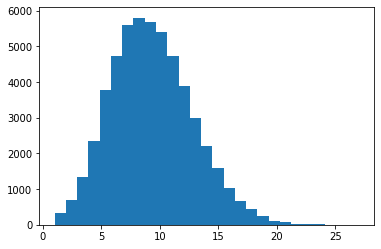

In [18]:
my_lda.topics_per_doc(model, corpus)

### Run search using model

In [19]:
questions_df = pd.read_csv('data/processed/questions_expert.csv', sep='\t', index_col=0)

In [20]:
# # concatenate full background to questions
# def q_plus_bg(row):
#     return row.question + ' ' + row.background
# questions_df['full_query'] = questions_df.apply(q_plus_bg, axis=1)
# queries = questions_df.full_query.tolist()

# main question only
queries = questions_df.question.tolist()

def write_results_to_file(query, df, dest_path):
    with open(dest_path, 'w') as file:
        file.write(query + '\n\n')
        for i in range(len(df)):
            row = df.iloc[i]
            file.write(f"Result #{i+1}: uid {row.cord_uid} \n")
            file.write(row.title + '\n')
            file.write(f"Abstract: \n {row.abstract} \n\n")

results_dir = save_directory+filename
os.mkdir(results_dir)

for i in range(len(queries)):
    query = queries[i]
    results_df = my_lda.lda_search(query, model, corpus, corpus.dictionary, df)
    dest_path = results_dir + f'/q{i}'
    write_results_to_file(query, results_df, dest_path) 

100%|██████████| 53758/53758 [01:00<00:00, 891.32it/s]


# Investigate model predictions

In [7]:
def word_topics(word_id):
    return(model.get_term_topics(word_id, minimum_probability=None))

In [8]:
def print_pred(query, corpus, model):
    print(query, '\n')
    query = clean_text_lda(query)
    print(query, '\n')
    q_vec = corpus.dictionary.doc2bow(query.split())
    print("bow: ")
    for i, n in q_vec:
        print(corpus.id2word[i], n)
    pred = model[q_vec]
    pred.sort(key=lambda x: x[1])
    pred = pred[::-1]
    print("\nTopic predictions: ")
    print(pred, '\n')
    for word, _ in q_vec:
        print(corpus.id2word[word], word_topics(word))

In [27]:
query = 'How do cytokine pathways link sleep and immunity to infection and COVID-19?'
print_pred(query, corpus, model)

How do cytokine pathways link sleep and immunity to infection and COVID-19? 

cytokine pathways link sleep immunity infection covid19 

bow: 
cytokine 1
immunity 1
sleep 1
pathways 1

Topic predictions: 
[(3, 0.437682), (69, 0.20494775), (67, 0.16335882)] 

cytokine [(3, 0.013277443)]
immunity [(67, 0.019903159)]
sleep [(69, 0.015996542)]
pathways []


In [ ]:
# mean

In [32]:
# # run search on query, return results_df
# results_df = my_lda.lda_search(query, model, corpus, corpus.dictionary, df)
# for title in results_df.title.values:
#     print(title, '\n')

In [31]:
# # see topic terms
# for i, n in model.get_topic_terms(69, topn=50):
#     print(model.id2word[i], n)

In [ ]:
# def topics_per_word(model, corpus):
    
#     def word_topics(word_id):
#     return(model.get_term_topics(word_id, minimum_probability=None))
    
#     for i in corpus.dictionary.token2id.values:
        